In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sigmf
from sigmf import sigmffile, SigMFFile
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

## Load the dataset


In [2]:
filename = 'data/dataset'
sigFile = sigmffile.fromfile(filename, skip_checksum=True)
annotations = sigFile.get_annotations()
nSignals = len(annotations)
# TODO: For now, I'm assuming all the data has the same length
nSamps = int(sigFile.sample_count/nSignals)
# The input data is a tensor with shape nSignals x 2 x nSamps
x = np.zeros((nSignals, 2, nSamps))
labels = np.array(['']*nSignals, dtype=object)
for iSignal, annotation in enumerate(annotations):
    # Label of the current signal
    labels[iSignal] = annotation[SigMFFile.LABEL_KEY]
    # Start index of the current signal
    annotationStart = annotation[SigMFFile.START_INDEX_KEY]
    # Length of the current signal in samples
    annotationLength = annotation[SigMFFile.LENGTH_INDEX_KEY]
    # Data for the current signal
    samples = sigFile.read_samples(annotationStart, annotationLength)
    # Store the signal data in the input tensor
    # Note: Since the data is complex, we need to split it into real and imaginary
    # parts because neural networks have trouble handling complex data
    x[iSignal, 0, :] = np.real(samples)
    x[iSignal, 1, :] = np.imag(samples)
# Number of unique signal classes
classes = np.unique(labels)


## Partition the data into training and testing sets


In [3]:
np.random.seed(0)
nTrain = int(0.5*nSignals)
nTest = nSignals - nTrain
# Since the input data is heavily structured, we need to shuffle the data to
# form the training and testing sets
trainIndex = np.random.permutation(range(0, nSignals))[0:nTrain]
# The test set is the complement of the training set
testIndex = list(set(range(0, nSignals)) - set(trainIndex))
# Generate the train/test examples/labels
xTrain = x[trainIndex, :, :]
xTest = x[testIndex, :, :]
labelTrain = labels[trainIndex]
labelTest = labels[testIndex]
inputShape = list(xTrain.shape[1:])
print(xTrain.shape)

(10000, 2, 128)


## Convert the class labels to one-hot vectors


In [4]:
def onehot(array):
  """
  Convert a list of labels to onehot representation
  """
  # Get the array of unique labels and the indices of the unique array that can
  # be used to reconstruct array
  unique, inverse = np.unique(array,return_inverse=True)
  # Each row of this identity matrix is the one-hot representation of each label
  # in unique, so we can get the one-hot encoding by choosing the corresponding
  # row for each index in inverse
  oh = np.eye(unique.shape[0])[inverse]
  return oh
yTrain = onehot(labelTrain)
yTest = onehot(labelTest)

## Try with the pickle file

In [5]:
# import pickle
# Xd = pickle.load(open('data/RML2016.10a_dict.pkl','rb'),encoding='latin')
# # Get the unique SNR values and labels from the dictionary above
# snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
# X = []
# lbl = []
# for mod in mods:
#   for snr in snrs:
#     X.append(Xd[mod,snr])
#     for i in range(Xd[(mod,snr)].shape[0]):
#       lbl.append((mod,snr))
# X = np.vstack(X)
# np.random.seed(2016)
# n_examples = X.shape[0]
# n_train = int(n_examples * 0.5)
# train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
# test_idx = list(set(range(0,n_examples))-set(train_idx))
# xTrain = X[train_idx]
# xTest =  X[test_idx]
# def to_onehot(yy):
#     yy = list(yy)
#     yy1 = np.zeros([len(yy), max(yy)+1])
#     yy1[np.arange(len(yy)),yy] = 1
#     return yy1
# yTrain = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
# yTest = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))
# in_shp = list(xTrain.shape[1:])
# print(xTrain.shape, in_shp)
# classes = mods

(110000, 2, 128) [2, 128]


## Build the model using Tensorflow


In [6]:
# CNN imports
# TODO: Move these to the top of the file
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Reshape, ZeroPadding2D, Conv2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras import Sequential
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Build the model
#   - Reshape the [N,2,128] input to [N,1,2,128]
dropoutRate = 0.5
model = Sequential()
model.add(Reshape(in_shp+[1],
                  input_shape=in_shp))
model.add(ZeroPadding2D((2,0),
                        data_format='channels_first'))
model.add(Conv2D(256, (1, 3),
                 activation='relu',
                 padding='valid',
                 name='conv1'))
model.add(Dropout(dropoutRate))
model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(80, (2, 3),
                 padding='valid',
                 activation='relu',
                 name='conv2'))
model.add(Dropout(dropoutRate))
model.add(Flatten())
model.add(Dense(256,
                activation='relu', kernel_initializer='he_normal', name='dense1'))
model.add(Dropout(dropoutRate))
model.add(Dense(len(classes),
                kernel_initializer='he_normal', name='dense2'))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='Adam')
model.summary()

Num GPUs Available:  1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 2, 132, 1)        0         
 2D)                                                             
                                                                 
 conv1 (Conv2D)              (None, 2, 130, 256)       1024      
                                                                 
 dropout (Dropout)           (None, 2, 130, 256)       0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 2, 134, 256)      0         
 ng2D)                                                           
                                                                 
 conv2 (Conv2D)              (Non

2021-11-07 11:16:33.637566: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-07 11:16:34.454099: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14069 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


## Train the model

In [7]:
nEpochs = 100
batchSize = 1024
history = model.fit(xTrain,yTrain,
                    batch_size=batchSize,
                    epochs=nEpochs,
                    validation_data=(xTest,yTest),
                    verbose=2,
                    callbacks = [
                      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto'),
                    ])

Epoch 1/100


2021-11-07 11:16:35.963923: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8300
2021-11-07 11:16:37.100443: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.194, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


108/108 - 12s - loss: 2.2504 - val_loss: 2.1382 - 12s/epoch - 108ms/step
Epoch 2/100
108/108 - 8s - loss: 1.9936 - val_loss: 1.8707 - 8s/epoch - 74ms/step
Epoch 3/100
108/108 - 8s - loss: 1.8470 - val_loss: 1.7618 - 8s/epoch - 73ms/step
Epoch 4/100
108/108 - 8s - loss: 1.7642 - val_loss: 1.6606 - 8s/epoch - 74ms/step
Epoch 5/100
108/108 - 8s - loss: 1.6892 - val_loss: 1.5924 - 8s/epoch - 75ms/step
Epoch 6/100
108/108 - 8s - loss: 1.6230 - val_loss: 1.4961 - 8s/epoch - 74ms/step
Epoch 7/100
108/108 - 8s - loss: 1.5495 - val_loss: 1.4534 - 8s/epoch - 73ms/step
Epoch 8/100
108/108 - 8s - loss: 1.5061 - val_loss: 1.3881 - 8s/epoch - 74ms/step
Epoch 9/100
108/108 - 8s - loss: 1.4720 - val_loss: 1.3852 - 8s/epoch - 73ms/step
Epoch 10/100
108/108 - 8s - loss: 1.4549 - val_loss: 1.3481 - 8s/epoch - 74ms/step
Epoch 11/100
108/108 - 8s - loss: 1.4344 - val_loss: 1.3492 - 8s/epoch - 71ms/step
Epoch 12/100
108/108 - 8s - loss: 1.4214 - val_loss: 1.3264 - 8s/epoch - 72ms/step
Epoch 13/100
108/108 -

1.2890750169754028


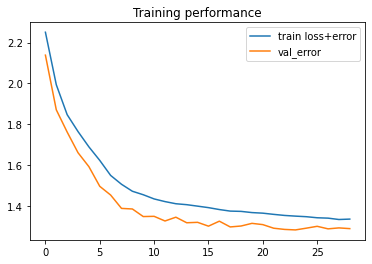

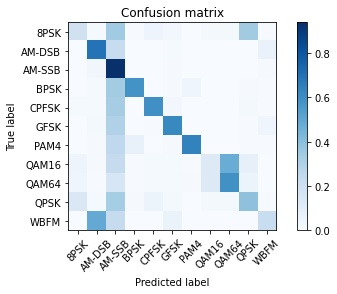

In [13]:
score = model.evaluate(xTest,yTest,verbose=0,batch_size=batchSize)
print(score)
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
plt.show()

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Plot confusion matrix
test_Y_hat = model.predict(xTest, batch_size=batchSize)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,xTest.shape[0]):
    j = list(yTest[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)